# Machine Learning 2022-2023 - UMONS

# Model selection using scikit-learn

**During the last lab, we learned how to fit a simple model to a single or multiple features to predict a given target variable. However, by fixing the number of features and by fixing the model's hyperparameters beforehand, we restricted ourselves to a single model. By doing so, we omitted to explore a broader range of models, one of which might better explain the relationship between our input and target variables.**

**In this lab, we'll experiment with the general methodology of model selection, meaning that we'll define a set of predefined models, and we'll retain the one that minimizes the out-of-sample error.**

**Import the necessary libraries**

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder

**1) In this lab, we will work with the [Fish market](https://www.kaggle.com/datasets/aungpyaeap/fish-market) dataset, which contains several characteristics about fish, such as their weights, lengths, and species. Load the dataset as a Pandas dataframe, inspect its properties and check for any missing values. Change the data type of 'Species' to 'category'.**

In [26]:
df = pd.read_csv('data/fish_lab.csv', index_col=0)
df = df.astype({'Species': 'category'})
print(df.dtypes)
print(df.isna().sum())
df.head()

Species    category
Weight      float64
Length1     float64
Length2     float64
Length3     float64
Height      float64
Width       float64
dtype: object
Species     5
Weight      8
Length1     7
Length2    12
Length3     3
Height      0
Width       5
dtype: int64


,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


**2) Does the dataframe contain any missing values ? If yes, replace the missing values by the sample mean for continuous variables. For missing categorical variables, replace them by the most frequent occurence of the corresponding column. You can use the `SimpleImputer` class of scikit-learn.**

In [27]:
imp_cont = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_cat = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

cat_columns = df.select_dtypes(include=['category']).columns
cont_columns = df.select_dtypes(exclude=['category']).columns

df[cat_columns] = imp_cat.fit_transform(df[cat_columns])
df[cont_columns] = imp_cont.fit_transform(df[cont_columns])

print(df.isna().sum())

Species    0
Weight     0
Length1    0
Length2    0
Length3    0
Height     0
Width      0
dtype: int64


**3) As in the previous lab, create a one-hot-encoding of the categorical variable using the `OneHotEncoder` class.** 

In [28]:
ohe = OneHotEncoder(drop='first')
dummies = ohe.fit_transform(df[['Species']])
dummies = pd.DataFrame(dummies.toarray())

dummies.columns = ohe.categories_[0][1:]

# Alternative to the above 4 lines:
# dummies = pd.get_dummies(df['Species'], drop_first=True)

df = df.drop('Species', axis=1)
df = pd.concat([dummies, df], axis=1)
print(df.columns)

Index(['Parkki', 'Perch', 'Pike', 'Roach', 'Smelt', 'Whitefish', 'Weight',
       'Length1', 'Length2', 'Length3', 'Height', 'Width'],
      dtype='object')


**4) We will start by predicting the target 'Height' from the feature 'Weight'. Split your datasets into a training and test set following a 60/40 partition using the `train_test_split` function. Then generate a scatter plot of the two variables.**

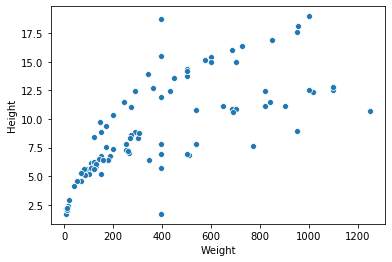

In [29]:
X = df[['Weight']]
y = df[['Height']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.6, test_size=0.4, shuffle=True, random_state=0
)

sns.scatterplot(x=X_train['Weight'], y=y_train['Height'])

**5) We can see that a linear model would not be the best option to model the relationship between these variables. Instead of fitting a linear model, let's fit a polynomial model of specified degree.**

- **Create your model using `PolynomialRegression` with `degree=2` and make sure to understand what the `make_pipeline` method does.**
- **Fit your model with 10-fold cross-validation using the `cross_validate` function.**
- **Report the mean of the test MSE across each folds based on the result of `cross_validate`.**

In [30]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

In [31]:
model = PolynomialRegression(2, fit_intercept=True)
cv_results = cross_validate(model, X_train, y_train, cv=10, scoring=['neg_mean_squared_error'])

test_mse = -cv_results['test_neg_mean_squared_error'].mean()
print(f'Test MSE for a polynomial model of degree 2: {test_mse}')

Test MSE for a polynomial model of degree 2: 7.242962800789272


**6) Let's now see how predictions vary with the model complexity. For polynomial degrees between 1 and 5, repeatedly fit the polynomial regression model (without cross-validation) and plot the predictions of 'Height' in function of the feature 'Weight'.**

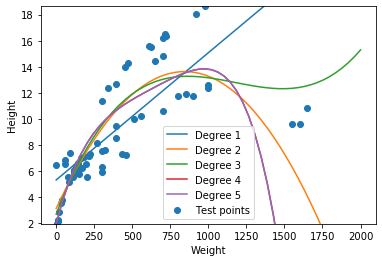

In [32]:
models = []
degrees = range(1, 6)
for degree in degrees:
    model = PolynomialRegression(degree, fit_intercept=True)
    model.fit(X_train, y_train)
    models.append(model)

fig, ax = plt.subplots()
ax.scatter(X_test, y_test, label='Test points')
X_plot = pd.DataFrame({'Weight': np.linspace(0, 2000)})
for model in models:
    degree = model.get_params()['polynomialfeatures__degree']
    y_plot_pred = model.predict(X_plot)
    ax.plot(X_plot, y_plot_pred, label=f'Degree {degree}')
ax.set_ylim([y_test['Height'].min(), y_test['Height'].max()])
ax.set(xlabel='Weight', ylabel='Height')
ax.legend()

**7) Plot the evolution of the train and test MSE of the 5 models from the previous question in function of the polynomial degree. What do you observe?**

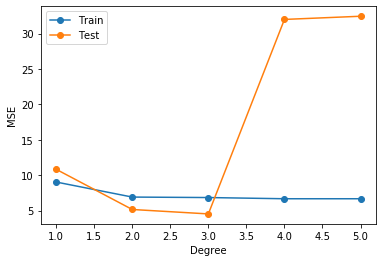

In [33]:
mse_train_list, mse_test_list = [], []
for model in models:
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    mse_train_list.append(train_mse)
    mse_test_list.append(test_mse)

fig, ax = plt.subplots()
ax.plot(degrees, mse_train_list, '-o', label='Train')
ax.plot(degrees, mse_test_list, '-o', label='Test')
ax.set(xlabel='Degree', ylabel='MSE')
ax.legend()

The model overfits when the degree is greater than 4.

**8) In the rest of this lab, we will predict the target 'Height' based on all available features. Split again your dataset into a training and test set following a 60/40 partition using the `train_test_split` function.**

In [34]:
X = df[df.columns.drop('Height')]
y = df[['Height']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.6, test_size=0.4, shuffle=True, random_state=0
)

**9) Usually, models have more than one hyperparameter that can be tuned in order to find the model that best captures the relationship between our input and target variables. For instance, in the case of a simple linear regression using a polynomial transformation on the input variables, the hyperparameter space would be the polymial's degree, and whether or not to fit the intercept. Inspecting each combination of hyperparameters and selecting the combination that results in the best model is called grid search. However, manually inspecting each combination could be a very tedious task, but fortunatly, scikit-learn provides a class `GridSearchCV()` that implements this protocol for you.**

**Select all features and 'Height' as target variable, and perform a grid search on the hyperparameter space of a polynomial regression model. Search for degrees varying between 1 and 5, and whether or not the intercept should be fit. Report the best hyperparameters and the corresponding MSE.**

In [35]:
param_grid = {
    'polynomialfeatures__degree': np.arange(1, 6),
    'linearregression__fit_intercept': [True, False],
}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=10, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

cv_results = pd.DataFrame(grid.cv_results_)
best_test_mse = -cv_results['mean_test_score'].max()

print(f'Best hyperparameters subset: {grid.best_params_}')
print(f'Test MSE using best hyperparameters subset: {best_test_mse}')

Best hyperparameters subset: {'linearregression__fit_intercept': False, 'polynomialfeatures__degree': 1}
Test MSE using best hyperparameters subset: 1.5347127082629168


**10) Finally, fit a model using the best hyperparameters on the full training dataset and report the MSE.**

In [36]:
model = PolynomialRegression().set_params(**grid.best_params_)
y_pred = model.fit(X_train, y_train).predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Test MSE using the full training dataset: {mse}')

Test MSE using the full training dataset: 1.2333582787060888


We observe that the MSE decreases when the full training dataset is available.